# Using Least Squares CycleGAM Model to Generate Monet-like Photos

## Introduction
In this project, we explore Monet's masterful style using Least Square CycleGAN technology. This model will transform ordinary images into Impressionist masterpieces by learning the bidirectional mapping between two domains: reality and Monet's artistic vision. 

Unlike traditional GANs, CycleGAN masters this transformation without paired training examples. The least squares approach, on the other hand, ensures more stable training and higher-quality results. 

Through an intricate system of cycle consistency losses and adversarial networks, we'll generate thousands of images that capture the ethereal essence of Monet's revolutionary artistic style.

In [2]:
import os
import shutil
#os.environ['KERAS_BACKEND'] = 'tensorflow'

from os.path import isfile, join

import matplotlib.pyplot as plt
import numpy as np
import zipfile

import tensorflow as tf
from tensorflow.data import TFRecordDataset
from tensorflow.io import parse_single_example, FixedLenFeature
from tensorflow.image import decode_jpeg

import keras

from keras.layers import (Input, GroupNormalization, Conv2D, Conv2DTranspose, 
                          Activation, LeakyReLU, Layer, ZeroPadding2D)

from keras.initializers import RandomNormal

from keras.losses import MeanSquaredError, MeanAbsoluteError
from keras.models import Model

from keras.optimizers import Adam

from keras.utils import plot_model, array_to_img

from keras import ops


print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.1


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
session = tf.compat.v1.Session(config=config)

## Dataset

According to [I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started/data), the dataset is a bunch of real photos and Monet paintings. They are provided in two different formats: jpeg and TFRecird

* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
* monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
* photo_jpg - 7028 photos sized 256x256 in JPEG format
* photo_tfrec - 7028 photos sized 256x256 in TFRecord format

We will use TFRecord.

Let's load the data:

In [3]:
base_path = '/kaggle/input/gan-getting-started'
#base_path = './'
img_shape = [256, 256, 3]

monet_path = os.path.join(base_path, 'monet_tfrec')
photo_path = os.path.join(base_path, 'photo_tfrec')

monet_files = [os.path.join(monet_path, f) 
               for f in os.listdir(monet_path) 
               if isfile(join(monet_path, f))]
photo_files = [os.path.join(photo_path, f) 
               for f in os.listdir(photo_path) 
               if isfile(join(photo_path, f))]

The data is 8 bits RGB. We need to covert from $[0; 255]$ domaint to $[-1;1]$. We will do it using the next method

In [4]:
def tfrecord_to_img(example):
    feature_keys = {
        'image_name': FixedLenFeature([], tf.string),
        'image': FixedLenFeature([], tf.string),
        'target': FixedLenFeature([], tf.string),
    }
    record = parse_single_example(example, feature_keys)
    img = decode_jpeg(record['image'], channels = 3)
    img = tf.cast(img, tf.float32)/127.5-1
    img = tf.reshape(img, img_shape)
    return img
photo_ds = TFRecordDataset(photo_files)
photo_ds = photo_ds.map(tfrecord_to_img)

monet_ds = TFRecordDataset(monet_files)
monet_ds = monet_ds.map(tfrecord_to_img)

Let's take a look at several Monet and real images from the dataset:

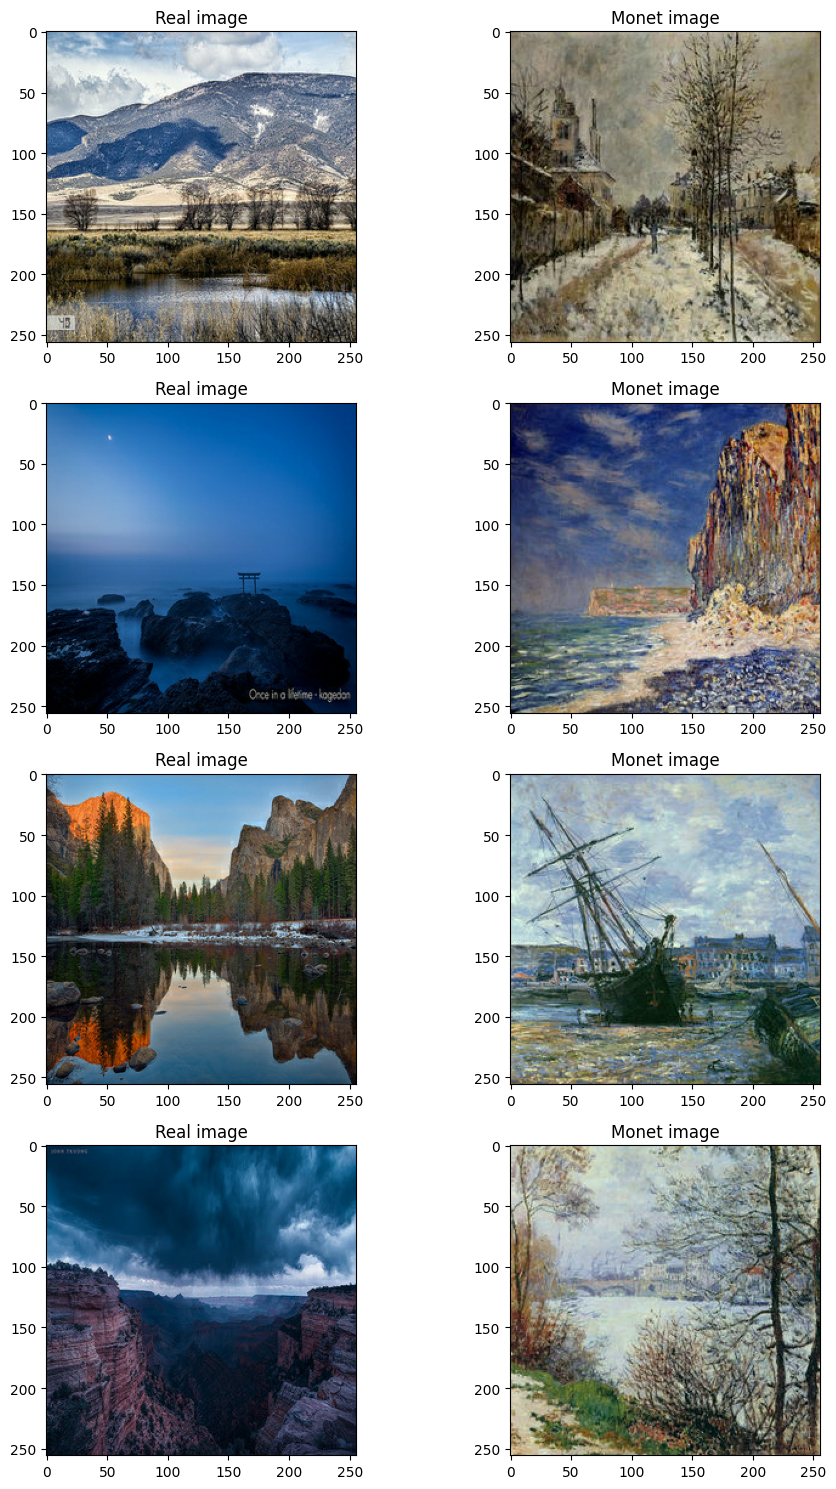

In [5]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(photo_ds.take(4), monet_ds.take(4))):
    ax[i, 0].imshow((samples[0] + 1)/2)
    ax[i, 1].imshow((samples[1] + 1)/2)
    ax[i, 0].set_title("Real image")
    ax[i, 1].set_title("Monet image")
plt.tight_layout()
plt.show()

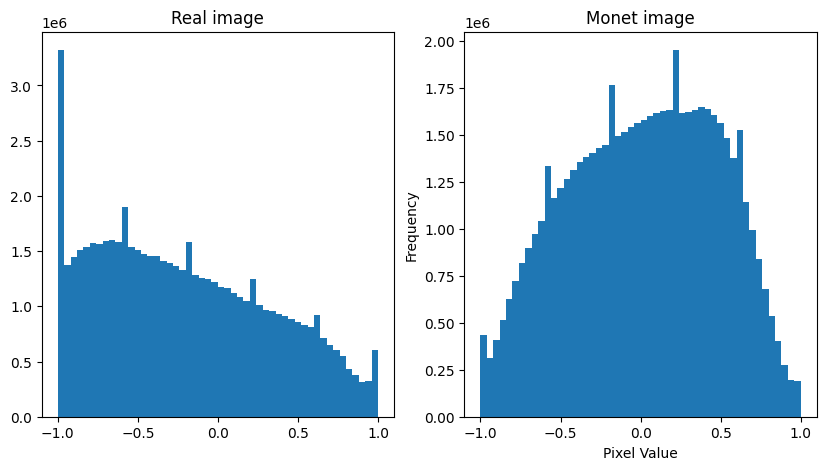

In [6]:
data = []
for img in photo_ds.shuffle(256).take(300):
    data.extend(img.numpy().flatten())

real_data = np.array(data)

data = []
for img in monet_ds:
    data.extend(img.numpy().flatten())

monet_data = np.array(data)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(real_data, bins=50)
ax[0].set_title("Real image")
ax[1].hist(monet_data, bins=50)
ax[1].set_title("Monet image")
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

We can see that the distributions are quite different for real images and Monet.

The GAN is a model that captures the conditional distribution and then generates a sample from that distribution. Let's see how it will handle this problem.

## Least Square CycleGAM with ResNet Blocks

CycleGAN is a generative adversarial network (GAN) designed for unsupervised image-to-image style translation. Meaning it can transform images from one domain to another without requiring paired training data. For example, it can convert photos of horses into zebras, daytime scenes into nighttime, or realistic images into artistic paintings. 

The key innovation of CycleGAN is its use of cycle consistency loss. It ensures that translating an image from the source domain to the target domain and back again reconstructs the original image. This cyclic constraint helps maintain the structural integrity of the input while adapting its style or appearance to the target domain. 

CycleGAN consists of two generators and two discriminators working in tandem. 

According to [A Gentle Introduction to Generative Adversarial Network Loss Functions](https://machinelearningmastery.com/generative-adversarial-network-loss-functions/) there are multiple different loss functions used with CycleGAN. The standard one uses binary cross-entropy. The formulas for Generator and Discriminator are:

$$\mathcal{L}_G=E_{\hat{x}\sim p_g}[log(1-D(\hat{x}))]$$
$$\mathcal{L}_D=-E_{x \sim p_d}[log(D(x))]-E_{\hat{x}\sim p_g}[log(1-D(\hat{x}))]$$

But here, we will use another loss function, which is based on mean squared error. It better deals with the vanishing gradient problem. "...it gives more penalty to larger errors, in turn resulting in a large correction rather than a vanishing gradient and no model update." Here are the formulas for loss function for least squared GAN:

$$\mathcal{L}_G=-E_{\hat{x}\sim p_g}[(D(\hat{x})-1))^2]$$
$$\mathcal{L}_D=-E_{x \sim p_d}[(D(x)-1))^2]-E_{\hat{x}\sim p_g}[D(\hat{x})^2]$$

### GAN architecture
Another topic is how to build the GAN network. In this project, we will use ResNet as a basis.

The ResNet block consists of a residual block, the one with the 'bypass' and the downsample block. 

We will base our CycleGAN on the Keras example [CycleGAN](https://keras.io/examples/generative/cyclegan/). But will use different architecture for GAN blocks

In [7]:
def downsample(x, filters, activation,
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.02),
               kernel_size=(3, 3), strides=(2, 2),
               padding="same", gamma_initializer=RandomNormal(mean=0.0, stddev=0.02),
               use_bias=False,
              ):
    x = Conv2D(filters, kernel_size, strides=strides,
               kernel_initializer=kernel_initializer, padding=padding,
               use_bias=use_bias,
              )(x)
    x = GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [8]:
def residual_block(x, activation,
                   kernel_initializer=RandomNormal(mean=0.0, stddev=0.02),
                   kernel_size=(3, 3), strides=(1, 1), padding="valid",
                   gamma_initializer=RandomNormal(mean=0.0, stddev=0.02),
                   use_bias=False):
    dim = x.shape[-1]
    input_tensor = x

    x = ZeroPadding2D()(input_tensor)
    x = Conv2D(dim, kernel_size, strides=strides, kernel_initializer=kernel_initializer,
               padding=padding, use_bias=use_bias,
              )(x)
    x = GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ZeroPadding2D()(x)
    x = Conv2D(dim, kernel_size, strides=strides, kernel_initializer=kernel_initializer,
               padding=padding, use_bias=use_bias,
              )(x)
    x = GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(x)
    x = keras.layers.add([input_tensor, x])
    return x

In [9]:
def upsample(x, filters, activation, kernel_size=(3, 3), strides=(2, 2), padding="same",
             kernel_initializer=RandomNormal(mean=0.0, stddev=0.02),
             gamma_initializer=RandomNormal(mean=0.0, stddev=0.02),
             use_bias=False):
    x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding,
                        kernel_initializer=kernel_initializer, use_bias=use_bias,
                       )(x)
    x = GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [10]:
def resnet_block(filters, x):
    x = residual_block(x, activation=Activation("relu"))
    x = residual_block(x, activation=Activation("relu"))
    x = residual_block(x, activation=Activation("relu"))
    #downsample
    filters *= 2
    x = downsample(x, filters=filters, activation=Activation("relu"))
    return (filters, x)

In [11]:
def get_generator(input_shape, filters = 64, num_downsamling=3, name = None):

    initializer = RandomNormal(0., 0.02)
    gama_initializer = RandomNormal(0., 0.02)
    
    img_input = Input(shape=input_shape)
    x = ZeroPadding2D(padding=(3, 3))(img_input)
    x = Conv2D(filters, (7, 7), kernel_initializer=initializer, use_bias=False)(x)
    x = GroupNormalization(groups=1, gamma_initializer=gama_initializer)(x)
    x = Activation("relu")(x)

    for _ in range(num_downsamling):
        filters, x = resnet_block(filters, x)

    for _ in range(num_downsamling):
        filters //= 2
        x = upsample(x, filters, activation=Activation("relu"))

    # Final block
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(3, (7, 7), padding="valid")(x)
    x = Activation("tanh")(x)

    model = Model(img_input, x, name=name)
    return model
    

In [12]:
def get_discriminator(input_shape, filters = 64, name = None):
    initializer = RandomNormal(0., 0.02)
    
    img_input = Input(shape=input_shape)
    x = Conv2D(filters, (4, 4), strides=(2, 2), 
               padding="same",kernel_initializer=initializer,)(img_input)
    x = LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        strides = (1, 1)
        if num_downsample_block < 2:
            strides = (2, 2)
        x = downsample(x, filters=num_filters, activation=LeakyReLU(0.2),
                       kernel_size=(4, 4), strides=strides)

    x = Conv2D(1, (4, 4), strides=(1, 1), 
               padding="same", kernel_initializer=initializer)(x)

    model = Model(inputs=img_input, outputs=x, name=name)
    return model


In [13]:
# Get the generators
gen_g = get_generator(img_shape, num_downsamling=3, name="generator_G")
gen_f = get_generator(img_shape, num_downsamling=3, name="generator_F")

# Get the discriminators
disc_x = get_discriminator(img_shape, name="discriminator_X")
disc_y = get_discriminator(img_shape, name="discriminator_Y")

In [14]:
gen_g.summary()

Model: "generator_G"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization       │ (None, 256, 256, 64)   │            128 │ conv2d[0][0]           │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ group_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 258, 258, 64)   │              0 │ activation[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,864 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_1     │ (None, 256, 256, 64)   │            128 │ conv2d_1[0][0]         │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ group_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 258, 258, 64)   │              0 │ activation_1[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         36,864 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_2     │ (None, 256, 256, 64)   │            128 │ conv2d_2[0][0]         │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 256, 64)   │              0 │ activation[0][0],      │
│                           │                        │                │ group_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 258, 258, 64)   │              0 │ add[0][0]              │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 64)   │         36,864 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_3

 Total params: 7,768,451 (29.63 MB)

 Trainable params: 7,768,451 (29.63 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
disc_x.summary()

Model: "discriminator_X"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 64, 64, 128)         │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_50               │ (None, 64, 64, 128)         │             256 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 32, 32, 256)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_51               │ (None, 32, 32, 256)         │             512 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 32, 32, 512)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_52               │ (None, 32, 32, 512)         │           1,024 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 32, 32, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,765,633 (10.55 MB)

 Trainable params: 2,765,633 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
class CycleGan(keras.Model):
    def __init__(self, gen_g, gen_f, disc_x, disc_y, lambda_cycle=10.0, lambda_identity=0.5):
        super().__init__()
        self.gen_g = gen_g
        self.gen_f = gen_f
        self.disc_x = disc_x
        self.disc_y = disc_y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def call(self, inputs):
        return (self.disc_x(inputs),self.disc_y(inputs),
                self.gen_g(inputs), self.gen_f(inputs))

    def compile(self, gen_g_optimizer, gen_f_optimizer, 
                disc_x_optimizer, disc_y_optimizer):
        super().compile()
        self.gen_g_optimizer = gen_g_optimizer
        self.gen_f_optimizer = gen_f_optimizer
        self.disc_x_optimizer = disc_x_optimizer
        self.disc_y_optimizer = disc_y_optimizer

    def train_step(self, batch_data):
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            
            fake_y = self.gen_g(real_x, training=True)
            fake_x = self.gen_f(real_y, training=True)

            cycled_x = self.gen_f(fake_y, training=True)
            cycled_y = self.gen_g(fake_x, training=True)

            same_x = self.gen_f(real_x, training=True)
            same_y = self.gen_g(real_y, training=True)

            disc_real_x = self.disc_x(real_x, training=True)
            disc_fake_x = self.disc_x(fake_x, training=True)

            disc_real_y = self.disc_y(real_y, training=True)
            disc_fake_y = self.disc_y(fake_y, training=True)

            gen_g_loss = self.__gen_loss(disc_fake_y)
            gen_f_loss = self.__gen_loss(disc_fake_x)

            cycle_loss_g = MeanAbsoluteError()(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_f = MeanAbsoluteError()(real_x, cycled_x) * self.lambda_cycle

            id_loss_g = MeanAbsoluteError()(real_y, same_y) * self.lambda_cycle * self.lambda_identity
            id_loss_f = MeanAbsoluteError()(real_x, same_x) * self.lambda_cycle * self.lambda_identity

            total_loss_g = gen_g_loss + cycle_loss_g + id_loss_g
            total_loss_f = gen_f_loss + cycle_loss_f + id_loss_f

            disc_x_loss = self.__discr_loss(disc_real_x, disc_fake_x)
            disc_y_loss = self.__discr_loss(disc_real_y, disc_fake_y)

        grads_g = tape.gradient(total_loss_g, self.gen_g.trainable_variables)
        grads_f = tape.gradient(total_loss_f, self.gen_f.trainable_variables)

        disc_x_grads = tape.gradient(disc_x_loss, self.disc_x.trainable_variables)
        disc_y_grads = tape.gradient(disc_y_loss, self.disc_y.trainable_variables)

        self.gen_g_optimizer.apply_gradients(zip(grads_g, self.gen_g.trainable_variables))
        self.gen_f_optimizer.apply_gradients(zip(grads_f, self.gen_f.trainable_variables))

        self.disc_x_optimizer.apply_gradients(zip(disc_x_grads, self.disc_x.trainable_variables))
        self.disc_y_optimizer.apply_gradients(zip(disc_y_grads, self.disc_y.trainable_variables))

        return {
            "G_loss": total_loss_g,
            "F_loss": total_loss_f,
            "D_X_loss": disc_x_loss,
            "D_Y_loss": disc_y_loss,
        }

    def __discr_loss(self, real, fake):
        real_loss = MeanSquaredError()(ops.ones_like(real), real)
        fake_loss = MeanSquaredError()(ops.zeros_like(fake), fake)
        return (real_loss + fake_loss) / 2.0

    def __gen_loss(self, fake):
        return MeanSquaredError()(ops.ones_like(fake), fake)


In [17]:
train_photos = photo_ds.cache().shuffle(256).batch(1)
train_monet = monet_ds.cache().shuffle(256).batch(1)

In [18]:
model = CycleGan(gen_g, gen_f, disc_x, disc_y)

model.compile(
    gen_g_optimizer=Adam(learning_rate=2e-4, beta_1=0.5),
    gen_f_optimizer=Adam(learning_rate=2e-4, beta_1=0.5),
    disc_x_optimizer=Adam(learning_rate=2e-4, beta_1=0.5),
    disc_y_optimizer=Adam(learning_rate=2e-4, beta_1=0.5),
)


hist = model.fit(
    tf.data.Dataset.zip((train_photos, train_monet)),
    epochs = 10,
)


Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 385s 603ms/step - D_X_loss: 0.0725 - D_Y_loss: 0.0622 - F_loss: 5.7715 - G_loss: 5.4598
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 183s 609ms/step - D_X_loss: 0.0811 - D_Y_loss: 0.0582 - F_loss: 4.4910 - G_loss: 4.2321
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 184s 611ms/step - D_X_loss: 0.0694 - D_Y_loss: 0.1161 - F_loss: 4.4126 - G_loss: 3.8923
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 182s 608ms/step - D_X_loss: 0.0604 - D_Y_loss: 0.1593 - F_loss: 4.1854 - G_loss: 3.7455
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 183s 611ms/step - D_X_loss: 0.0461 - D_Y_loss: 0.1578 - F_loss: 4.1744 - G_loss: 3.6806
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 183s 610ms/step - D_X_loss: 0.0411 - D_Y_loss: 0.1544 - F_loss: 4.2860 - G_loss: 3.6577
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 183s 609ms/step - D_X_loss: 0.0770 - D_Y_loss: 0.1086 - F_loss: 4.0949 - G_loss: 3.6754
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 183s 609ms/step - D_X_loss: 0.0599 - D_Y_loss: 0.1141 - F_loss: 4.0857 - G_loss: 3.6021
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 183s 610ms/step - D_X_loss: 0.1716 - D_Y_loss: 0.0720 - F_loss: 3.7668 - G_

## Evaluation
Lets take a look at the generated images

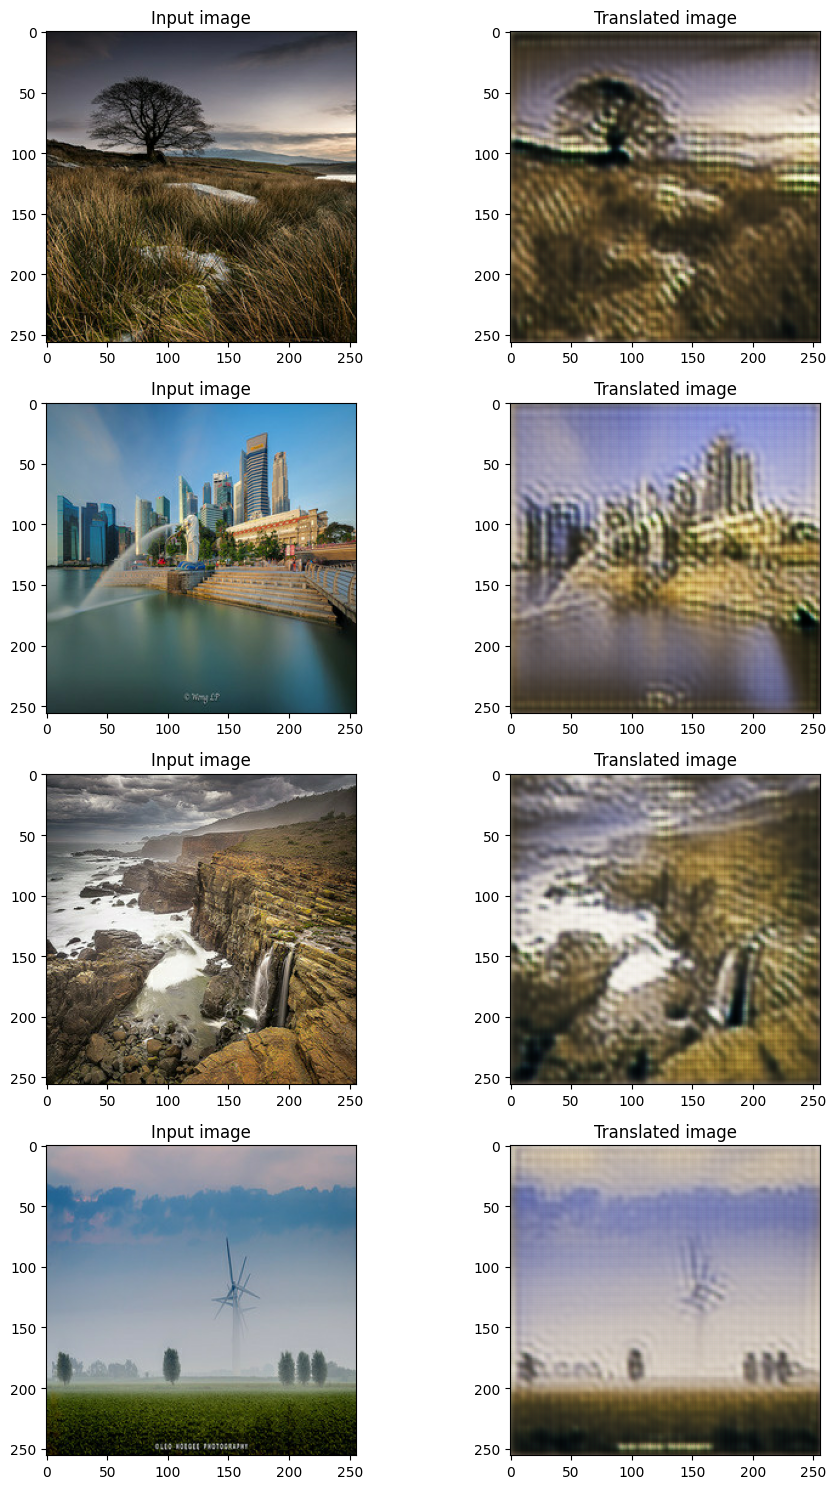

In [19]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(train_photos.take(4)):
    prediction = model.gen_g(img, training=False)[0].numpy()
    prediction = ((prediction + 1)*127.5).astype(np.uint8)
    img = ((img[0] + 1)*127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
plt.tight_layout()
plt.show()

Quite impressive.

Now, let's look at the training history:

In [20]:
def plot_history(history, to_show=[('D_X_loss', 'D_Y_loss'), ('F_loss', 'G_loss')]):
    _, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    for w, ax in zip(to_show, axs):
        for e in w:
            ax.plot(history.history[f'{e}'], label=f'{e}')
        ax.legend(loc='lower right')
    
    plt.show()

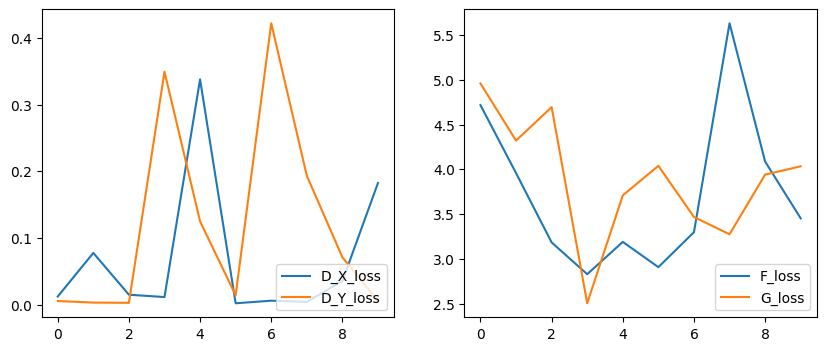

In [21]:
plot_history(hist)

The history shows that it converges very slowly. So, the 10 epochs are likely not enough.

I tried to run 90 epochs, and it showed improvement in all the metrics. So, the assumption is correct.

## Differen Architecture Consideration
I've tested 3 different architectures of GANs training over 20 epocs. Using from two to four ResNet blocks with downsampling.
Here are the results in [kaggel competition](https://www.kaggle.com/competitions/gan-getting-started/overview):
| GAN Archittecuter  | Score   |
| ------------------- | ------- |
| Two ResNet blocks   | 78.5    |
| Three ResNet blocks | 104.0   |
| Four ResNet blocks  | 142.0   |

Three ResNet block architecture trained over 90 epochs outperformed all the mentioned above with the MiFID score around **69.2**


## Output
Here, we will prepare a submission to [Kagge competition](https://www.kaggle.com/competitions/gan-getting-started/overview)

In [ ]:
dirpath = './images'

if os.path.exists(dirpath) and os.path.isdir(dirpath):
    shutil.rmtree(dirpath)
try:
    os.mkdir(dirpath)
    print(f"Directory '{dirpath}' created successfully.")
except FileExistsError:
    print(f"Directory '{dirpath}' already exists.")
except FileNotFoundError:
     print("Parent directory does not exist.")


for i, img in enumerate(iter(photo_ds.batch(1))):
    prediction = model.gen_g(img, training=False)[0].numpy()
    prediction = ((prediction + 1)*127.5).astype(np.uint8)
    prediction = array_to_img(prediction)
    prediction.save(os.path.join(dirpath, "predicted_img_{i}.png".format(i=i)))
    if i%100 == 0:
        print(f'Processed {i}')

In [ ]:
zip_filename = "images.zip"
try:
    os.remove(zip_filename)
except:
    pass

files_to_zip = [f for f in os.listdir(dirpath) 
               if isfile(join(dirpath, f))]

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as img_zip:
    for filename in files_to_zip:
        img_zip.write(join(dirpath, filename), arcname=filename)

## Summary
In this project, we designed an LS CycleGAN network with a ResNet-based Generator for the task of style transfer. The architecture leveraged the strengths of CycleGAN for unpaired image-to-image translation, while the ResNet blocks in the generator enhanced feature extraction and learning capabilities. 

Overall, the model demonstrated strong performance in capturing and transferring artistic styles between domains. The best-performing configuration utilized three ResNet blocks and was trained over 90 epochs. It achieved a balance between computational efficiency and output quality. This setup effectively minimized artifacts and preserved content integrity.

We can further investigate the potential of combining CycleGAN with ResNet for complex style transfer tasks. Also, we can try different deep-learning models for Discriminators and other loss functions.

## References
1. A_K_Nain. 2020. CycleGAN. Keras. Retrieved Feb 18, 2025, from https://keras.io/examples/generative/cyclegan/
2. Jason Brownlee. 2019. A Gentle Introduction to Generative Adversarial Network Loss Functions. Machine Learning Mastery. Retrieved Feb 18, 2025, from https://machinelearningmastery.com/generative-adversarial-network-loss-functions/